# Metodo de solucion de ecuaciones diferenciales ordinarias por elementos fintios (Galerkin y debilitacion)
En esta sección revisaremos la formulación de un programa para la solución de una ecuación diferencial y el acople de varios de estos para la solucion de sistemas de ecuaciones diferenciales ordinarias de cualquier orden.

 * Unicamente debemos cumplir con que la ecuación o el sistma de ecuaciones sea lineal

Para este proceso presentamos una base funcional como la que se trabajo en el proceso de aproximar funciones y no discretizaremos los dominios aun.


In [9]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import Legendre, leggauss

In [10]:
def gauss_legendre_integral(f, a, b, n=80):
    """Integra f(x) en [a,b] usando cuadratura Gauss–Legendre con n puntos."""
    xi, wi = leggauss(n)  # puntos y pesos en [-1,1]
    # Mapeo lineal a [a,b]
    x_mapped = 0.5 * (b - a) * xi + 0.5 * (b + a)
    w_mapped = 0.5 * (b - a) * wi
    return np.dot(w_mapped, f(x_mapped))
# ---- Ensamblaje global de K y F -----------------------------------------
def assemble_KF(M, f, xi, xf, quad_n=80):
    """Construye las matrices globales K y F para el sistema Galerkin."""
    K = np.zeros((M, M))
    F = np.zeros(M)
    for i in range(M):
        for j in range(M):
            K[i, j] = Ke(i, j, xi, xf, quad_n=quad_n)
        F[i] = Fe(i, f, xi, xf, quad_n=quad_n)
    return K, F


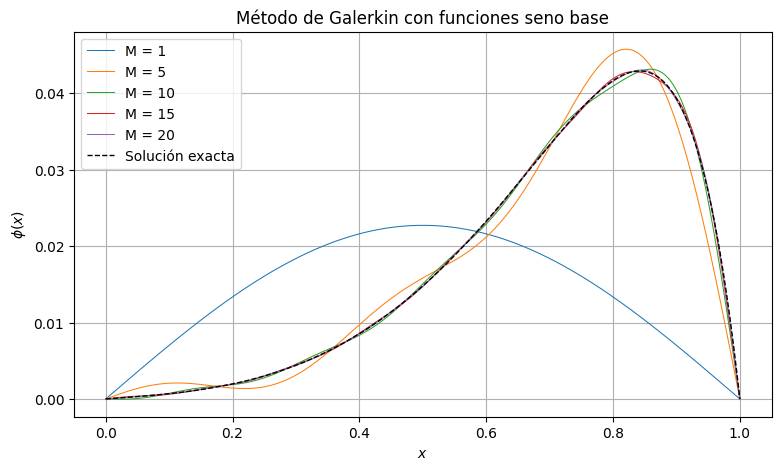

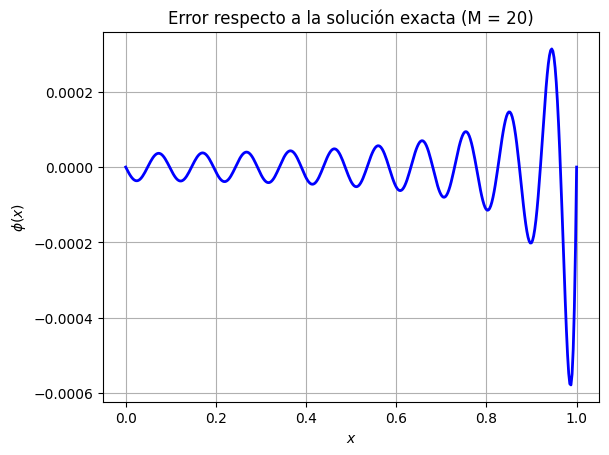

In [11]:
#Definimos las funciones para el caso
# ---- Definimos las funciones de aproximacion ----------------------------
def Nm(x, m):
    """Función base senoidal."""
    return np.sin(m * np.pi * x)
def dNm(x, m):
    """Primera derivada de la base senoidal."""
    return (m * np.pi) * np.cos(m * np.pi * x)
# ---- Términos locales Ke(i,j) y Fe(i) -----------------------------------
def Ke(i, j, xi, xf, quad_n=80):
    """Calcula el término K_ij = ∫ [k * dNi*dNj + a*Ni*Nj] dx"""
    integrand = lambda x: (0.1) * dNm(x, i+1) * dNm(x, j+1) + (10) * Nm(x, i+1) * Nm(x, j+1)
    return gauss_legendre_integral(integrand, xi, xf, n=quad_n)
def Fe(i, f, xi, xf, quad_n=80):
    """Calcula el término F_i = ∫ f(x)*N_i dx"""
    integrand = lambda x: f(x) * Nm(x, i+1)
    return gauss_legendre_integral(integrand, xi, xf, n=quad_n)
# ---- Solucion exacta -----------------------------------
def f_exacta(x):
    """Solución analítica de -k f'' + a f = x^3, f(0)=f(1)=0"""
    return -(np.exp(-10*x)*(-53*np.exp(10)+((50-50*np.exp(20))*x**3+(3-3*np.exp(20))*x)*np.exp(10*x)+53*np.exp(10+20*x)))/(500*np.exp(20)-500)
#---------CASO--------------------------------------------
xi, xf = 0.0, 1.0
f = lambda x: x**3
X = np.linspace(xi, xf, 400)
M_values = np.linspace(1, 20, 5, dtype=int)
plt.figure(figsize=(9, 5))
for M in M_values:
        # Ensamble global
        K, F = assemble_KF(M, f, xi, xf, quad_n=100)
        # Resolver sistema lineal
        a = np.linalg.solve(K, F)
        # Aproximación con las M funciones seno
        f_approx = np.zeros_like(X)
        for j in range(M):
            f_approx += a[j] * Nm(X, j+1)
        plt.plot(X, f_approx, lw=0.75, label=f"M = {M}")
    # Solución exacta
plt.plot(X, f_exacta(X), 'k--', lw=1, label='Solución exacta')
plt.xlabel(r'$x$')          # <-- string raw evita warnings
plt.ylabel(r'$\phi(x)$')
plt.title('Método de Galerkin con funciones seno base')
plt.legend()
plt.grid(True)
plt.show()
# --- Ensamble y solución para el último M ---
M = M_values[-1]
K, F = assemble_KF(M, f, xi, xf, quad_n=120)
a = np.linalg.solve(K, F)

# --- Aproximación numérica ---
f_approx = np.zeros_like(X)
for j in range(M):
    f_approx += a[j] * Nm(X, j+1)

# --- Solución exacta ---
f_ex = f_exacta(X)

# --- Error puntual ---
E = f_approx - f_ex

plt.figure()
plt.plot(X, E, '-b', lw=2)
plt.xlabel(r'$x$')          # <-- string raw evita warnings
plt.ylabel(r'$\phi(x)$')
plt.title(f'Error respecto a la solución exacta (M = {M})')
plt.grid(True)
plt.show()


In [12]:
L = 1
nq = 50
E = 30e9       # [Pa]
gamma = 15e3   # [N/m³]
R = 0.25       # Radio mayor [m]
r = 0.15       # Radio menor [m]

# =======================================================
# FUNCIONES AUXILIARES
# =======================================================
def A(x):
    """Área variable"""
    return np.pi * (-(r - R)*x + R)**2

def gauss_quad_vec(func, a, b, n=80):
    """Integración Gauss-Legendre (vectorizada)."""
    xi, wi = leggauss(n)
    xm = 0.5*(b - a)*xi + 0.5*(b + a)
    return 0.5*(b - a) * np.dot(wi, func(xm))

I_tot = gauss_quad_vec(lambda s: A(s), 0.0, L, n=nq)

def I_of_x(xval, n=nq):
    """I(x) = ∫₀ˣ A(s) ds"""
    if np.isscalar(xval):
        if xval <= 0: return 0.0
        return gauss_quad_vec(lambda s: A(s), 0.0, xval, n=n)
    else:
        return np.array([0.0 if xv <= 0 else gauss_quad_vec(lambda s: A(s), 0.0, xv, n=n)
                         for xv in xval])

def u_exact_gauss(X, n_inner=nq, n_outer=None):
    """
    u(x) = ∫₀ˣ γ*(I_tot - I(t)) / (E*A(t)) dt
    """
    if n_outer is None:
        n_outer = n_inner
    X = np.atleast_1d(X)
    U = np.zeros_like(X, dtype=float)
    for idx, xv in enumerate(X):
        if xv <= 0:
            U[idx] = 0.0
            continue
        xi, wi = leggauss(n_outer)
        t_nodes = 0.5*xv*xi + 0.5*xv
        I_t = np.array([0.0 if tn <= 0 else gauss_quad_vec(lambda s: A(s), 0.0, tn, n=n_inner)
                        for tn in t_nodes])
        gt = gamma * (I_tot - I_t) / (E * A(t_nodes))
        U[idx] = 0.5*xv * np.dot(wi, gt)
    return U

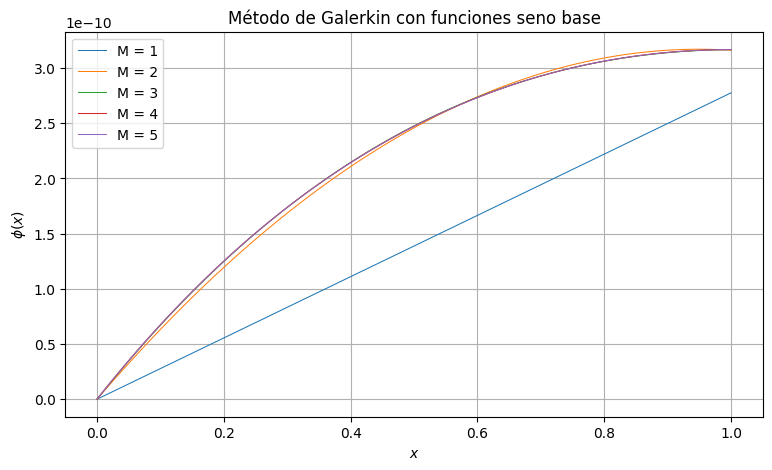

In [13]:
#Definimos las funciones para el caso
# ---- Definimos las funciones de aproximacion ----------------------------
def Nm(x, m):
    """Función base senoidal."""
    return x**m
def dNm(x, m):
    """Primera derivada de la base senoidal."""
    return (m)*x**(m-1)
# ---- Términos locales Ke(i,j) y Fe(i) -----------------------------------
def Ke(i, j, xi, xf, quad_n=80):
    """Calcula el término K_ij = ∫ [k * dNi*dNj + a*Ni*Nj] dx"""
    E = 30e9
    integrand = lambda x: E*A(x) * dNm(x, i+1) * dNm(x, j+1)
    return gauss_legendre_integral(integrand, xi, xf, n=quad_n)
def Fe(i, f, xi, xf, quad_n=80):
    """Calcula el término F_i = ∫ f(x)*N_i dx"""
    integrand = lambda x: Nm(x, i+1)*A(x)*15
    return gauss_legendre_integral(integrand, xi, xf, n=quad_n)
#---------CASO--------------------------------------------
xi, xf = 0.0, 1.0
f = lambda x: x**3
X = np.linspace(xi, xf, 100)
M_values = np.linspace(1, 5, 5, dtype=int)
# f_exacta = u_exact_gauss(X, n_inner=nq, n_outer=nq)
plt.figure(figsize=(9, 5))
for M in M_values:
        # Ensamble global
        K, F = assemble_KF(M, f, xi, xf, quad_n=100)
        # Resolver sistema lineal
        a = np.linalg.solve(K, F)
        # Aproximación con las M funciones seno
        f_approx = np.zeros_like(X)
        for j in range(M):
            f_approx += a[j] * Nm(X, j+1)
        plt.plot(X, f_approx, lw=0.75, label=f"M = {M}")
    # Solución exacta
# plt.plot(X, f_exacta, 'k--', lw=1, label='Solución exacta')
plt.xlabel(r'$x$')          # <-- string raw evita warnings
plt.ylabel(r'$\phi(x)$')
plt.title('Método de Galerkin con funciones seno base')
plt.legend()
plt.grid(True)
plt.show()


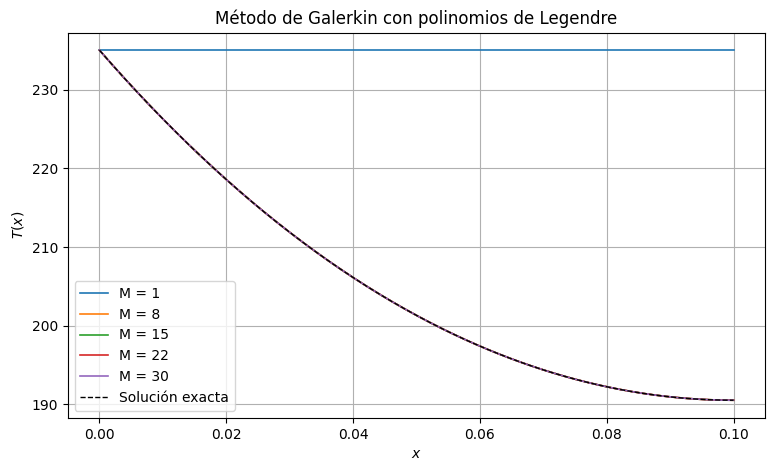

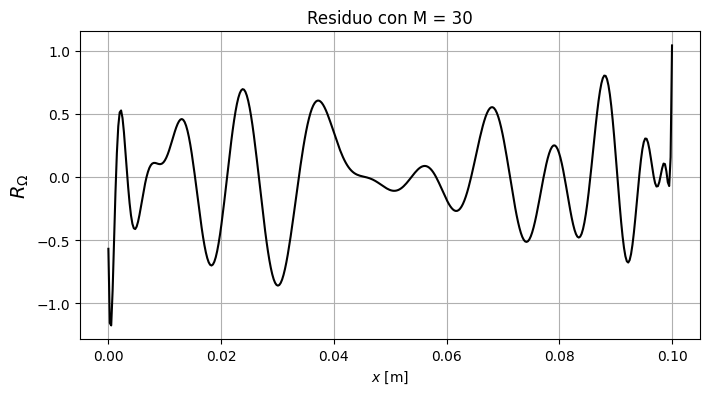

In [14]:
# ---- Mapeo a coordenadas del problema ----------------------------
def map_to_physical(xi):
    """Mapeo de coordenada local [-1,1] a física [0,L]."""
    return 0.5 * (xi + 1) * L

# ---- Funciones base para la aproximación --------------------------
def Nm(xi, m):
    """Polinomio de Legendre de orden m evaluado en xi ∈ [-1,1]."""
    return Legendre.basis(m)(xi)

def dNm(xi, m):
    """Primera derivada dP_m/dxi."""
    return Legendre.basis(m).deriv()(xi)

def d2Nm(xi, m):
    """Segunda derivada d²P_m/dxi²."""
    return Legendre.basis(m).deriv(2)(xi)

# ---- Cuadratura Gauss-Legendre -----------------------------------
def gauss_legendre_integral(f, a, b, n=80):
    """Integra f(x) en [a,b] usando cuadratura Gauss–Legendre."""
    xi, wi = leggauss(n)
    x_mapped = 0.5 * (b - a) * xi + 0.5 * (b + a)
    w_mapped = 0.5 * (b - a) * wi
    return np.dot(w_mapped, f(x_mapped))


# ---- Términos locales Ke(i,j) y Fe(i) -----------------------------
def Ke(i, j, xi, xf, quad_n=80):
    integrand = lambda xi: (4 / L**2) * dNm(xi, i) * dNm(xi, j) + alfa * Nm(xi, i) * Nm(xi, j)
    return gauss_legendre_integral(integrand, -1, 1, n=quad_n)

def Fe(i, xi, xf, quad_n=80):
    integrand = lambda xi: Nm(xi, i)
    return alfa * Tinf * gauss_legendre_integral(integrand, -1, 1, n=quad_n)
def assemble_KF(M, f, xi, xf, quad_n=80):
    K = np.zeros((M, M))
    F = np.zeros(M)
    for i in range(M):
        for j in range(M):
            K[i, j] = Ke(i, j, xi, xf, quad_n=quad_n)
        F[i] = Fe(i, xi, xf, quad_n=quad_n)   # <-- sin "f"
    return K, F
# ---- Penalización de condiciones de contorno ----------------------
def penalizacion(K, F, condiciones, L, penal=1e12):
    M = K.shape[0]
    for c in condiciones:
        x = c['x']
        tipo = c['tipo'].lower()
        valor = c['valor']
        # Mapeo x ∈ [0,L] → ξ ∈ [-1,1]
        xi = 2 * x / L - 1
        if tipo == 'dirichlet':
            Nvec = np.array([Nm(xi, m) for m in range(M)])
            K += penal * np.outer(Nvec, Nvec)
            F += penal * valor * Nvec
        elif tipo == 'neumann':
            dNdxi = np.array([dNm(xi, m) for m in range(M)])
            F += (2 / L) * valor * dNdxi
        else:
            raise ValueError(f"Tipo de condición desconocido: {tipo}")
    return K, F

# ---- Parámetros del caso físico ----------------------------------
L = 0.1      # [m]
hc = 9       # [W/m^2·°C]
k = 360      # [W/m·°C]
A_const = 0.001  # [m^2] (constante)
p = 2.002    # [m]
Tc = 235.0   # [°C]
Tinf = 20.0  # [°C]
alfa = hc * p / (k * A_const)   # coeficiente α (constante)
# Solucion exacta
C1 = np.sqrt(alfa)
def T_exacta(x):
    return np.exp(-C1*x) * (
        np.exp(2*C1*L)*Tc
        + np.exp(2*C1*x)*Tc
        - np.exp(2*C1*L)*Tinf
        + np.exp(C1*x)*Tinf
        - np.exp(2*C1*x)*Tinf
        + np.exp(2*C1*L + C1*x)*Tinf
    ) / (1 + np.exp(2*C1*L))
xi, xf = 0.0, L
X = np.linspace(xi, xf, 400)
M_values = np.linspace(1, 30, 5, dtype=int)

# ---- Condiciones de contorno -------------------------------------
condiciones = [
    {'x': 0.0, 'tipo': 'dirichlet', 'valor': Tc},   # T(0) = Tc
    {'x': L,   'tipo': 'neumann',  'valor': 0.0}    # dT/dx(L) = 0
]
# ---- Bucle principal: solución para varios M ----------------------
plt.figure(figsize=(9, 5))
for M in M_values:
    # Ensamble global
    K, F = assemble_KF(M, None, xi, xf, quad_n=100)
    K, F = penalizacion(K, F, condiciones, L)
    # Resolver sistema lineal
    a = np.linalg.solve(K, F)
    # Aproximación con las M funciones base
    xi_points = 2 * X / L - 1
    f_approx = np.zeros_like(X)
    for j in range(M):
        f_approx += a[j] * Nm(xi_points, j)
    plt.plot(X, f_approx, lw=1.2, label=f"M = {M}")
plt.plot(X, T_exacta(X), 'k--', lw=1, label='Solución exacta')
# ---- Gráfico -----------------------------------------------------
plt.xlabel(r'$x$')
plt.ylabel(r'$T(x)$')
plt.title('Método de Galerkin con polinomios de Legendre')
plt.legend()
plt.grid(True)
plt.show()
xi_points = 2 * X / L - 1  # mapeo físico → local
T_approx = np.zeros_like(X)
R = np.zeros_like(X)
for j in range(M):
    Pj = Legendre.basis(j)
    d2Pj = Pj.deriv(2)
    T_approx += a[j] * Pj(xi_points)
    # derivada segunda en x: d2/dx2 = (2/L)^2 * d2/dξ2
    R += a[j] * (alfa * Pj(xi_points) - (4 / L**2) * d2Pj(xi_points))
R -= alfa * Tinf
# --- Gráfico del residuo ------------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(X, R, '-k', lw=1.5)
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$R_\Omega$', fontsize=14)
plt.title(f'Residuo con M = {M}')
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/scipy/integrate/_bvp.py:1098: RuntimeWarning: invalid value encountered in divide
  r_middle = 1.5 * col_res / h
/usr/local/lib/python3.12/dist-packages/scipy/integrate/_bvp.py:592: RuntimeWarning: invalid value encountered in divide
  slope = (y[:, 1:] - y[:, :-1]) / h


solve_bvp no convergió: The maximum number of mesh nodes is exceeded.


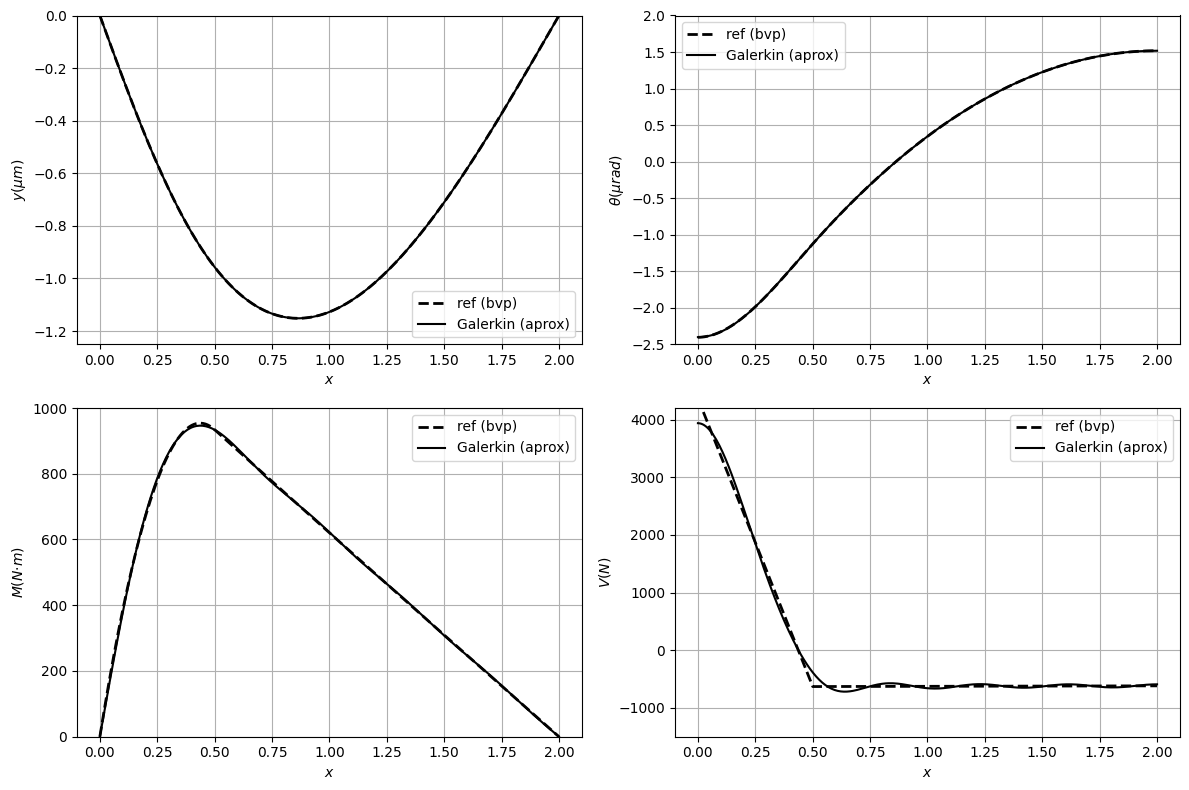

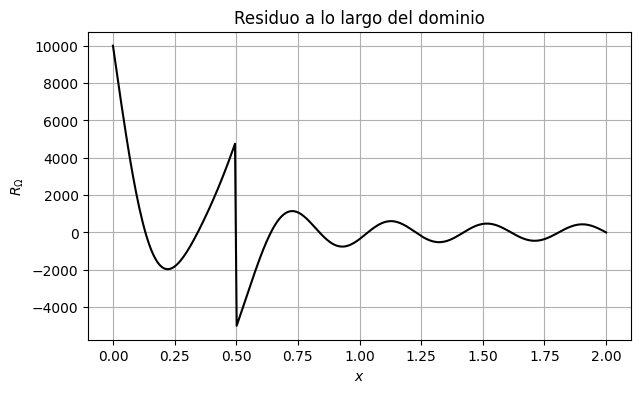

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss
from scipy.integrate import solve_bvp

# -------------------------
# Parámetros del problema
# -------------------------
L = 2.0            # [m]
k = 10e6           # [N/m^2]
w0 = -10e3         # [N/m]  (carga negativa)
I = 1320e-6        # [m^4]
E = 200e9          # [N/m^2]
EI = E * I

# --------------------------------------------------------
# Carga distribuida (escalón sobre 0..L/4)
# --------------------------------------------------------
def escalon(x):
    return np.where((x >= 0.0) & (x <= L/4.0), 1.0, 0.0)

def w_dist(x):
    return w0 * escalon(x)

# --------------------------------------------------------
# Base N_m(x)=sin(m*pi*x/L) y derivadas analíticas
# --------------------------------------------------------
def N_m(m, x):
    return np.sin(m * np.pi * x / L)

def dN_m(m, x):
    coef = (m * np.pi / L)
    return coef * np.cos(m * np.pi * x / L)

def d2N_m(m, x):
    coef2 = (m * np.pi / L)**2
    return -coef2 * np.sin(m * np.pi * x / L)

def d3N_m(m, x):
    coef3 = (m * np.pi / L)**3
    return -coef3 * np.cos(m * np.pi * x / L)

def d4N_m(m, x):
    coef4 = (m * np.pi / L)**4
    return coef4 * np.sin(m * np.pi * x / L)

# --------------------------------------------------------
# Integración Gauss-Legendre mapeada a [a,b]
# --------------------------------------------------------
def gauss_legendre_integral(f, a, b, n=80):
    xi, wi = leggauss(n)
    x_mapped = 0.5 * (b - a) * xi + 0.5 * (b + a)
    w_mapped = 0.5 * (b - a) * wi
    return np.dot(w_mapped, f(x_mapped))

# --------------------------------------------------------
# Términos elementales Ke y Fe (Galerkin con base sinus)
# K_ij = EI * ∫ d2Ni * d2Nj dx  + k * ∫ Ni * Nj dx
# F_i  = ∫ w(x) * Ni(x) dx  (solo sobre [0,L/4])
# --------------------------------------------------------
def Ke(i, j, a=0.0, b=L, quad_n=120):
    """Calcula K_ij sobre [a,b] (por defecto todo el dominio)."""
    integrand1 = lambda x: d2N_m(i, x) * d2N_m(j, x)   # para EI * ∫ d2i*d2j
    integrand2 = lambda x: N_m(i, x) * N_m(j, x)       # para k * ∫ Ni*Nj
    I1 = gauss_legendre_integral(integrand1, a, b, n=quad_n)
    I2 = gauss_legendre_integral(integrand2, a, b, n=quad_n)
    return EI * I1 + k * I2

def Fe(i, a=0.0, b_load=L/4.0, quad_n=120):
    """Calcula F_i = ∫_{a}^{b_load} w(x) * Ni(x) dx (carga en [0,L/4])."""
    integrand = lambda x: w_dist(x) * N_m(i, x)
    return gauss_legendre_integral(integrand, a, b_load, n=quad_n)

# --------------------------------------------------------
# Ensamblaje global K y F para M modos
# --------------------------------------------------------
def assemble_KF(M, quad_n=120):
    K = np.zeros((M, M))
    F = np.zeros(M)
    # índices modos: 1..M  (mantengo igual que tu matlab)
    for i in range(1, M+1):
        for j in range(1, M+1):
            K[i-1, j-1] = Ke(i, j, a=0.0, b=L, quad_n=quad_n)
        F[i-1] = Fe(i, a=0.0, b_load=L/4.0, quad_n=quad_n)
    return K, F

# --------------------------------------------------------
# Resolver Galerkin y evaluar aproximación y residuo
# --------------------------------------------------------
def galerkin_solve(M, quad_n=120, np_points=200):
    K, F = assemble_KF(M, quad_n=quad_n)
    a = np.linalg.solve(K, F)

    X = np.linspace(0.0, L, np_points)
    y_aprox = np.zeros_like(X)
    theta_aprox = np.zeros_like(X)
    M_aprox = np.zeros_like(X)
    V_aprox = np.zeros_like(X)
    R = np.zeros_like(X)
    for j in range(1, M+1):
        y_aprox += a[j-1] * N_m(j, X)
        theta_aprox += a[j-1] * dN_m(j, X)
        M_aprox += a[j-1] * d2N_m(j, X)
        V_aprox += a[j-1] * d3N_m(j, X)
        R += a[j-1] * (EI * d4N_m(j, X) + k * N_m(j, X))

    # residuo = (EI d4 y + k y) - w(x)
    R = R - w_dist(X)

    # momentos y cortantes multiplicados por EI
    M_aprox = EI * M_aprox
    V_aprox = EI * V_aprox

    return X, a, y_aprox, theta_aprox, M_aprox, V_aprox, R

# --------------------------------------------------------
# Solución de referencia con solve_bvp
# --------------------------------------------------------
def fun_bvp(x, y):
    dy = np.zeros_like(y)
    dy[0] = y[1]
    dy[1] = y[2]
    dy[2] = y[3]
    dy[3] = (-k * y[0] + w_dist(x)) / EI
    return dy

def bc_bvp(ya, yb):
    return np.array([ya[0],    # y(0) = 0
                     yb[0],    # y(L) = 0
                     ya[2],    # y''(0) = 0
                     yb[2]])   # y''(L) = 0

# --------------------------------------------------------
# Ejecutar y comparar
# --------------------------------------------------------
if __name__ == "__main__":
    M = 10
    X, a, y_aprox, theta_aprox, M_aprox, V_aprox, R = galerkin_solve(M, quad_n=2*M+6, np_points=300)

    # solve_bvp reference
    x_init = np.linspace(0, L, 201)
    y_guess = np.zeros((4, x_init.size))
    sol = solve_bvp(fun_bvp, bc_bvp, x_init, y_guess, tol=1e-8, max_nodes=5000)
    if not sol.success:
        print("solve_bvp no convergió:", sol.message)

    # Ploteo similar al tuyo
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs[0,0].plot(sol.x, sol.y[0,:] / 1e-6, '--k', linewidth=2.0, label='ref (bvp)')
    axs[0,0].plot(X, y_aprox / 1e-6, '-k', linewidth=1.5, label='Galerkin (aprox)')
    axs[0,0].grid(True); axs[0,0].set_xlabel('$x$'); axs[0,0].set_ylabel('$y (\\mu m)$')
    axs[0,0].legend(fontsize=10); axs[0,0].set_ylim([-1.25, 0])

    axs[0,1].plot(sol.x, sol.y[1,:] / 1e-6, '--k', linewidth=2.0, label='ref (bvp)')
    axs[0,1].plot(X, theta_aprox / 1e-6, '-k', linewidth=1.5, label='Galerkin (aprox)')
    axs[0,1].grid(True); axs[0,1].set_xlabel('$x$'); axs[0,1].set_ylabel('$\\theta (\\mu rad)$')
    axs[0,1].legend(fontsize=10); axs[0,1].set_ylim([-2.5, 2])

    axs[1,0].plot(sol.x, sol.y[2,:] * EI, '--k', linewidth=2.0, label='ref (bvp)')
    axs[1,0].plot(X, M_aprox, '-k', linewidth=1.5, label='Galerkin (aprox)')
    axs[1,0].grid(True); axs[1,0].set_xlabel('$x$'); axs[1,0].set_ylabel('$M (N·m)$')
    axs[1,0].legend(fontsize=10); axs[1,0].set_ylim([0, 1000])

    axs[1,1].plot(sol.x, sol.y[3,:] * EI, '--k', linewidth=2.0, label='ref (bvp)')
    axs[1,1].plot(X, V_aprox, '-k', linewidth=1.5, label='Galerkin (aprox)')
    axs[1,1].grid(True); axs[1,1].set_xlabel('$x$'); axs[1,1].set_ylabel('$V (N)$')
    axs[1,1].legend(fontsize=10); axs[1,1].set_ylim([-1500, 4200])

    plt.tight_layout()

    # Residuo
    plt.figure(figsize=(7,4))
    plt.plot(X, R, '-k', linewidth=1.5)
    plt.grid(True)
    plt.xlabel('$x$'); plt.ylabel('$R_\\Omega$')
    plt.title('Residuo a lo largo del dominio')
    plt.show()
